In [1]:
# make the fortran module using f2py if you haven't already
# f2py -c -m bottCC coad1dpy.f 

import bottCC as bcc # import the collision coalescence module
# set parameters 
# rq0 is the radius mode in microns
# xmw is the total water content in g/m3
# nbins is the number of bins (this is hard coded in the fortran code to be 400)
# dt is the time step in seconds 
rq0_in=10.
xmw_in=1.0
nbins=400
dt=1.0
g_out,r_out,dlnr_out = bcc.coad1d_init(rq0_in,xmw_in,nbins,dt)  # this initializes the arrays and sets the initial mass distribution
# r_out is the range of radii in microns
# g_out is the initial mass distribution in g/m3/ln(r) 
# g_out.sum()*dlnr_out is the total water content
# while subroutine coad1d_init analytically sets the initial mass distribution, 
# one can set the initial mass distribution to any distribution they want and 
# reset the initial mass distribution using subroutine set_g_initial
t=0.0
g_out=2*g_out
bcc.set_g_initial(g_out) # this resets the initial mass distribution to 2 times the initial mass distribution

while t<3600:
    g,t = bcc.integrate(nbins,dt,t)


A similar approach is described in paper "Parameterization of the collision–coalescence process using series of basis functions: COLNETv1.0.0 model development using a machine learning approach"
https://gmd.copernicus.org/articles/15/493/2022/gmd-15-493-2022.pdf.

* We are going to use an AutoEncoder (rather than moments) to describe the PSDs and parameterize their temporal dynamics.
* In addition, we are going to add a vertical dimension, sedimentation, and (eventually) evaporation and condensation.

(1e-11, 0.01)

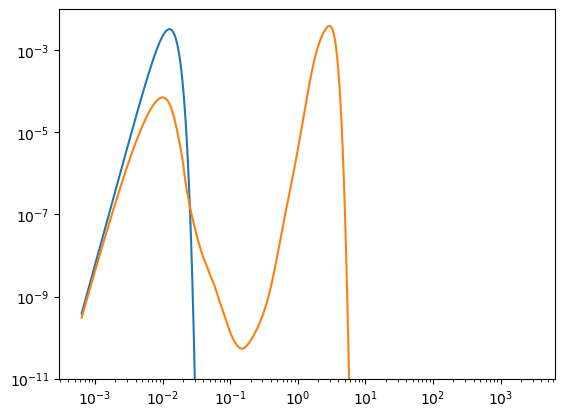

In [3]:

import matplotlib.pyplot as plt

plt.plot(r_out[:400]*1e-3,g_out[:400])
plt.xscale('log')
plt.yscale('log')

plt.plot(r_out[:400]*1e-3,g[:400])
plt.ylim(1e-11,1e-2) 


In [51]:
#from nGammaDSD import *
import nGammaDSD as nG  # import the normalized gamma dsd module
import importlib
importlib.reload(nG)

nw=0.08 # set the intercept parameter cm-4
lwc=np.arange(40)*0.1+0.05  # set the liquid water content in g/m3
mu=2.0  # set the shape parameter
f_mu=nG.fmu(mu) # get the f(mu) function
dm0=10*nG.dm_lwc(nw,lwc[0],1000) # get the mass mean diameter for a given lwc, nw and mu [in cm]
lwc1,mD,dInt=nG.getMassDist(nw,dm0,f_mu,mu,1000) # get the mass distribution for a given lwc, nw and mu

In [52]:
from scipy.ndimage import gaussian_filter1d
g_int=g_out.copy()*0.0 
# bin the mass distribution to the same bins as the collision coalescence code
for md1,d1 in zip(mD,dInt):
    ibin=np.log(d1/2*1e3)/dlnr_out
    g_int[int(ibin)]+=md1/dlnr_out*1e-3

g_int1=gaussian_filter1d(g_int,2.0) # smooth the mass distribution to remove binning artifacts
print(g_int.sum()*dlnr_out,lwc1,g_int1.sum()*dlnr_out)


5.000000267610383e-05 0.05000000001301696 4.9999993710220236e-05


In [53]:

t=0.0 # reset time to 0.0
bcc.set_g_initial(g_int1) # this resets the initial mass distribution to g_int

while t<3600:
    g,t = bcc.integrate(nbins,dt,t)


0.049999993710220236 0.049999993710220236


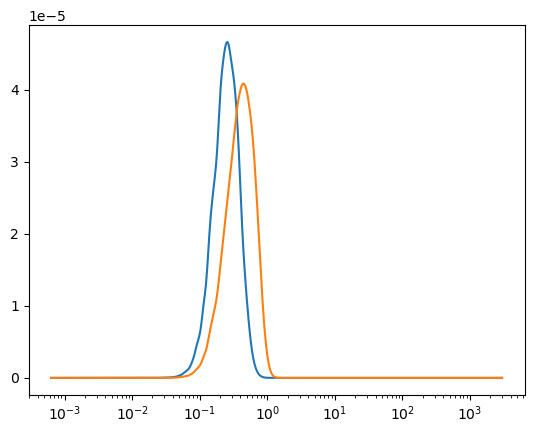

In [54]:

plt.plot(r_out[:400]*1e-3,g_int1[:400])
plt.plot(r_out[:400]*1e-3,g[:400])

plt.xscale('log')
#plt.yscale('log')

print(g.sum()*dlnr_out*1e3,g_int1.sum()*dlnr_out*1e3)

In [187]:
# everything together
import xarray as xr
np.random.seed(2023)
lwcL=[]
nwL=[]
dmL=[]
muL=[]
for irun in range(1,1001):
    nw=0.08*10**(np.random.randn()*2) # randomly choose a nw [cm-4]
    lwci=np.exp(np.random.randn()*1)  # randomly choose a lwc [g/m3]
    mu=np.random.rand()*4             # set mu
    f_mu=nG.fmu(mu)
    dm0=10*nG.dm_lwc(nw,lwci,1000)    # calculate dm0 in mm
    g_int=g_out.copy()*0.0
    lwcL.append(lwci)
    nwL.append(nw)
    dmL.append(dm0)
    muL.append(mu)
    lwc1,mD,dInt=nG.getMassDist(nw,dm0,f_mu,mu,1000) # get the mass distribution for a given lwc, nw and mu
    #print('dm=',(mD*dInt).sum()/mD.sum(),dm0)
    count=g_int.copy()*0.0
    for md1,d1 in zip(mD,dInt):
        ibin=np.log(d1/2*1e3/r_out[0])/dlnr_out
        g_int[int(ibin+0.5)]+=md1/dlnr_out*1e-3
        count[int(ibin+0.5)]+=1
    
    #mD is the mass within an equidistant dD=0.02 mm bin
    #therefore, we need to divide by dD to get mass per diameter distribution
    dD=dInt[1]-dInt[0]
    g_int2=np.interp(np.log(r_out[:]*1e-3),np.log(dInt/2),(mD/dD)/dlnr_out*1e-3)
    #we then need to multiply by the bin width to get the mass within the logarithmically spaced bins
    g_int2[:-1]=g_int2[:-1]*np.diff(r_out[:]*1e-3*2)
    
    #print('LWC=',g_int2.sum()*dlnr_out*1e3,lwc1,mD.sum(),g_int.sum()*dlnr_out*1e3)

    #print(g_int.sum()*dlnr_out,lwc1,g_int1.sum()*dlnr_out)
    #print(lwc1,lwci)

    t=0.0 # reset time to 0.0
    bcc.set_g_initial(g_int2) # this resets the initial mass distribution to g_int
    tlast=-999
    dtsave=20
    gL=[]
    while t<3600:
        g,t = bcc.integrate(nbins,dt,t)
        if t-tlast>dtsave:
            gL.append(g.copy())
            tlast=t
    g_=xr.DataArray(1e3*np.array(gL),dims=['time','radius'],coords={'time':np.arange(len(gL))*dtsave,'radius':r_out[:400]*1e-3})
    g_.attrs['units']='g/m3/ln(r)'
    g_.attrs['long_name']='Mass Distribution'
    g_.attrs['lwc']=lwci
    g_.attrs['nw']=nw
    g_.attrs['mu']=mu
    g_.attrs['dm0']=dm0
    g_.attrs['f_mu']=f_mu
    g_.attrs['dlnr']=dlnr_out
    g_.attrs['dInt']=dInt
    ds=xr.Dataset({'g':g_})
    ds.to_netcdf("dsd_out/dsd%3.3i.nc"%irun,encoding={'g':{'dtype':'float32','zlib':True,'complevel':5}})

import pickle
pickle.dump({'lwc':lwcL,'nw':nwL,'dm0':dmL,'mu':muL},open('dsdParams.pkl','wb'))

In [182]:
print('LWC=',g_int2.sum()*dlnr_out,lwc1,mD.sum(),g_int1.sum()*dlnr_out)

LWC= 0.0005162371260916296 0.5062814477247597 0.5062814477247597 0.0005062814261802551


In [184]:
dm2=(g_int2*2*r_out[:]*1e-3).sum()/g_int2.sum()
print(dm2,dm0)


0.5369207152753787 0.5370430393594837


In [185]:
print(516/506)

1.0197628458498025


2500.0 0.5370430393594837


(10, 1000.0)

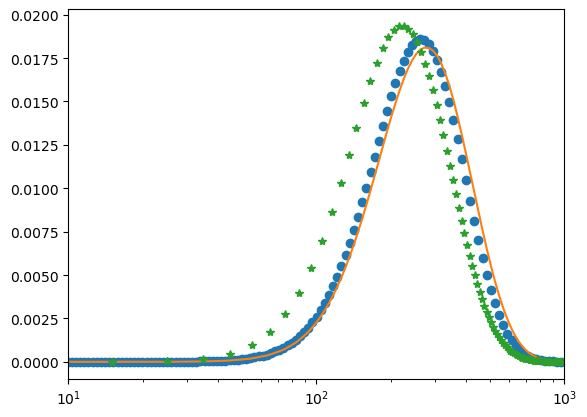

In [186]:

dm2=(md1*dInt).sum()/md1.sum()
print(dm2,dm0)
r_out_m=(r_out[:-1]+r_out[1:])/2
plt.plot(r_out_m,g_int2[1:]*dlnr_out*1e3,'o')
plt.plot(r_out_m,g[1:]*dlnr_out*1e3)
plt.plot(dInt/2*1e3,mD,'*')
plt.xscale('log')
plt.xlim(10,1e3)
#plt.yscale('log')

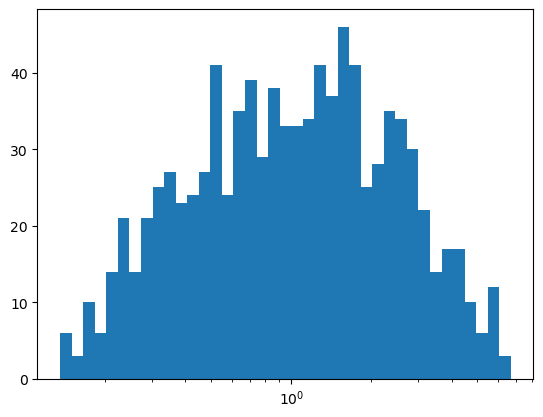

In [75]:
lwci=np.exp(np.random.randn(1000)*1)
h1=plt.hist(lwci,bins=np.exp(np.arange(-2,2,0.1)))
plt.xscale('log')